In [2]:
# default_exp gcp_elevation_api

# Traffic networks with google elevation api

> Integrating traffic networks with google elevation api for an area in Melbourne. Then calculate the shortest path which accounts for grade impedance.

- toc: true 
- badges: true
- comments: true
- categories: [elevation, googlemap, api]

In [3]:
#hide
from nbdev.showdoc import *

In [13]:
import os
import numpy as np
import geopandas as gpd
import osmnx as ox

In [6]:
# Setup google elevation api key
ELEVATION_API = os.environ.get('GCP_ELEVATION_API')

### Get a network and add elevation to its nodes

In [26]:
# Check number of nodes and edges of Greater Melbourne
GMB = ox.graph_from_place("Greater Melbourne, Victoria, Australia", network_type='all')
len(GMB.nodes), len(GMB.edges)

(380268, 960778)

In [28]:
# Check number of nodes and edges of City of Monash
GM = ox.graph_from_place("City of Monash, Victoria, Australia", network_type='all')
len(GM.nodes), len(GM.edges)

(13602, 32640)

##### Get a network by place

In [7]:
# Get for a small area
place = "Oakleigh"
place_query = "Oakleigh, the city of Monash, Victoria, 3166, Australia"
G = ox.graph_from_place(place_query, network_type='bike')

In [25]:
len(G.nodes), len(G.edges)

(611, 1431)

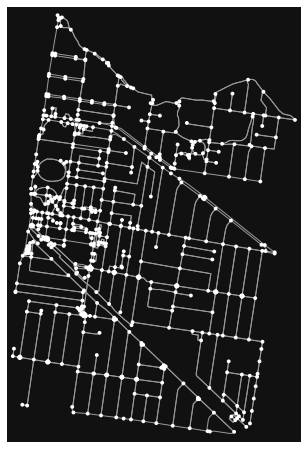

In [8]:
fig, ax = ox.plot_graph(G)

##### Get elevation data

In [9]:
# Add elevations to nodes, and grades to edges
G = ox.add_node_elevations(G, api_key=ELEVATION_API)
G = ox.add_edge_grades(G)

### Calculate several stats

##### Average and median grade

In [10]:
edge_grades = [data['grade_abs'] for u, v, k, data in ox.get_undirected(G).edges(keys=True, data=True)]

In [14]:
avg_grade = np.mean(edge_grades)
print('Average street grade in {} is {:.1f}%'.format(place, avg_grade*100))

Average street grade in Oakleigh is 1.9%


In [15]:
med_grade = np.median(edge_grades)
print('Median street grade in {} is {:.1f}%'.format(place, med_grade*100))

Median street grade in Oakleigh is 1.4%


##### Plot nodes by elevation

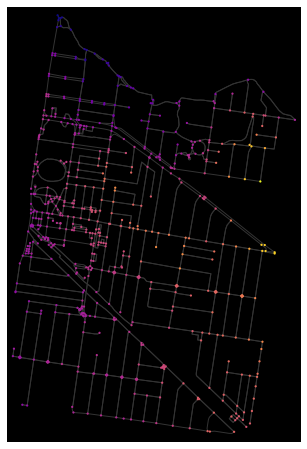

In [17]:
# get one color for each node by elevation
nc = ox.plot.get_node_colors_by_attr(G, 'elevation', cmap='plasma')
fig, ax = ox.plot_graph(G, node_color=nc, node_size=5, edge_color='#333333', bgcolor='k')

##### Plot the edges by grade

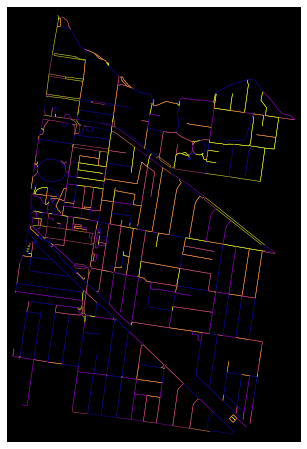

In [18]:
# get a color for each edge, by grade, then plot the network
ec = ox.plot.get_edge_colors_by_attr(G, 'grade_abs', cmap='plasma', num_bins=5, equal_size=True)
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=0.5, node_size=0, bgcolor='k')

### Shortest paths account for grade impedance

In [35]:
from shapely.geometry import Polygon, Point

In [36]:
# Select an origin and destination node
orig = (-37.8943, 145.0900)
dest = (-37.9059, 145.1030)
# Check the distance
Point(orig).distance(Point(dest))

0.017422973339822574

In [37]:
# Get nearest nodes and a bounding box
orig = ox.get_nearest_node(G, orig)
dest = ox.get_nearest_node(G, dest)
bbox = ox.utils_geo.bbox_from_point((-37.9001, 145.0965), dist=1500)

In [116]:
# An edge impedance function
def impedance(length, grade):
    penalty = grade ** 2
    return length * penalty

def impedance_2(length, grade):
    penalty = length * (np.abs(grade) ** 3)
    return penalty

In [117]:
for u, v, k, data in G.edges(keys=True, data=True):
#     data['impedance'] = impedance(data['length'], data['grade_abs'])
    data['impedance'] = impedance_2(data['length'], data['grade'])
    data['rise'] = data['length'] * data['grade']

#### First find the shortest path by minimising distance

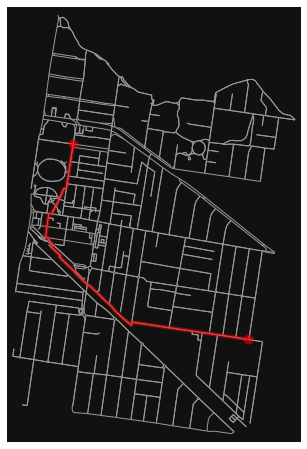

In [118]:
route_by_length = ox.shortest_path(G, orig, dest, weight='length')
fig, ax = ox.plot_graph_route(G, route_by_length, node_size=0)

#### Find the shortest path by minimising impedance

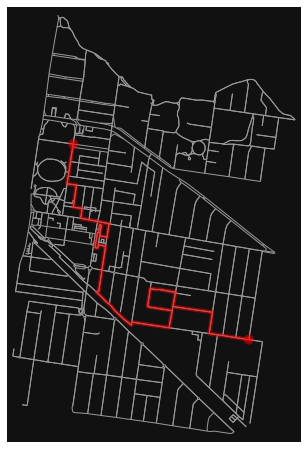

In [119]:
route_by_impedance = ox.shortest_path(G, orig, dest, weight='impedance')
fig, ax = ox.plot_graph_route(G, route_by_impedance, node_size=0)

#### Stats about these two routes

In [121]:
def print_route_stats(route):
    route_grades = ox.utils_graph.get_route_edge_attributes(G, route, 'grade_abs')
    msg = 'The average grade is {:.1f}% and the max is {:.1f}%'
    print(msg.format(np.mean(route_grades)*100, np.max(route_grades)*100))

    route_rises = ox.utils_graph.get_route_edge_attributes(G, route, 'rise')
    ascent = np.sum([rise for rise in route_rises if rise >= 0])
    descent = np.sum([rise for rise in route_rises if rise < 0])
    msg = 'Total elevation change is {:.1f} meters: a {:.0f} meter ascent and a {:.0f} meter descent'
    print(msg.format(np.sum(route_rises), ascent, abs(descent)))

    route_lengths = ox.utils_graph.get_route_edge_attributes(G, route, 'length')
    print('Total trip distance: {:,.0f} meters'.format(np.sum(route_lengths))) 


In [122]:
# stats of route minimizing length
print_route_stats(route_by_length)

The average grade is 1.5% and the max is 5.4%
Total elevation change is 12.3 meters: a 19 meter ascent and a 7 meter descent
Total trip distance: 2,273 meters


In [123]:
# stats of route minimizing impedance (function of length and grade)
print_route_stats(route_by_impedance)

The average grade is 1.1% and the max is 5.4%
Total elevation change is 12.4 meters: a 22 meter ascent and a 10 meter descent
Total trip distance: 3,423 meters
